# A quick run down of some of uncertainty estimations in frequentist inference

In [1]:
import numpy as np
from joblib import Parallel, delayed
import scipy.stats as st
from scipy.misc import derivative
from scipy.optimize import curve_fit, minimize
import matplotlib.pylab as plt
import matplotlib.colors as colors
from corner import corner
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

colorset = ['#000000','#00270C','#00443C','#005083',
            '#034BCA','#483CFC','#9C2BFF','#EB24F4',
            '#FF2DC2','#FF4986','#FF7356','#FFA443',
            '#EBD155','#D3F187','#D7FFC8','#FFFFFF']

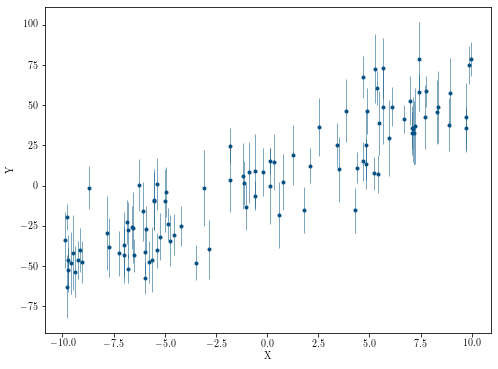

In [2]:
numpoints = 100
np.random.seed(seed=5496)
data_x = st.uniform.rvs(-10.0,20.0,numpoints)
data_y = 5.0 * data_x + 2.0 + st.norm.rvs(0.0,20.0,numpoints)
data_dy = 2*st.uniform.rvs(4.0,8.0,numpoints)
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(1,1,1)
ax.errorbar(data_x,data_y,data_dy,fmt='.',color=colorset[3],elinewidth=0.5)
ax.set(xlabel='X',ylabel='Y');

## The model to fit

Best-fit m: 5.46
Best-fit d: 4.31


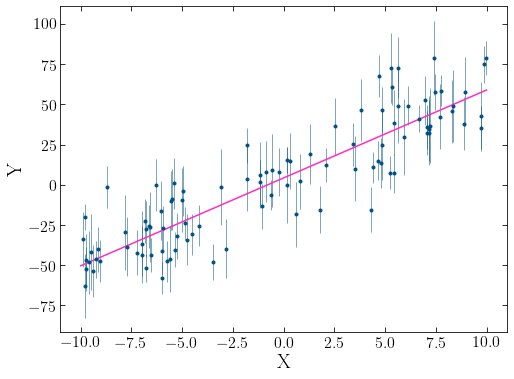

In [3]:
def model(x, m, d):
    return m*x+d

def negloglikelihood(theta, x, y, dy):
    m, d = theta
    return 0.5*np.sum(((y-model(x, m, d))/dy)**2)
    
min_res = minimize(negloglikelihood, [5, 5], args=(data_x,data_y, data_dy))

bestfit_m = min_res['x'][0]
bestfit_d = min_res['x'][1]

print(f'Best-fit m: {bestfit_m:.3}\nBest-fit d: {bestfit_d:.3}')

test_x = np.linspace(-10,10,100)
test_y = model(test_x,bestfit_m, bestfit_d)

fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(1,1,1)
ax.errorbar(data_x,data_y,data_dy,fmt='.',color=colorset[3],elinewidth=0.5)
ax.plot(test_x,test_y, color=colorset[8])
ax.set_xlabel('X',fontsize=20)
ax.set_ylabel('Y', fontsize=20)
ax.tick_params(axis='both', which='major', labelsize=16)
ax.tick_params(axis='both', which='major', length=5)
ax.tick_params(axis='both', which='minor', length=2.5)
ax.tick_params(axis='both', which='both',direction='in',right=True,top=True)

## Method 1: Fisher information (least reliable)

In [4]:
def negloglikelihood_fixed_m(d, x, y, dy):
    """
    Fixing one of the two parameters to allow estimating derivative with respect to a single parameter
    """
    m = min_res.x[0]
    return 0.5*np.sum(((y-model(x, m, d))/dy)**2)

def negloglikelihood_fixed_d(m, x, y, dy):
    """
    Fixing one of the two parameters to allow estimating derivative with respect to a single parameter
    """
    d = min_res.x[1]
    return 0.5*np.sum(((y-model(x, m, d))/dy)**2)

fisher_delta_d = np.sqrt(1./derivative(negloglikelihood_fixed_m,bestfit_d, n=2,args=[data_x,data_y,data_dy]))
fisher_delta_m = np.sqrt(1./derivative(negloglikelihood_fixed_d,bestfit_m, n=2,args=[data_x,data_y,data_dy]))

print(f'm: {bestfit_m:.3} +/- {fisher_delta_m:.2}')
print(f'd: {bestfit_d:.3} +/- {fisher_delta_d:.3}')

m: 5.46 +/- 0.23
d: 4.31 +/- 1.42


## Method 2: Bootstrap

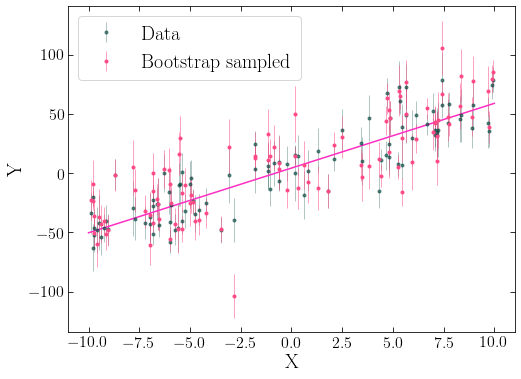

In [5]:
test_x = np.linspace(-10,10,100)
test_y = model(test_x,bestfit_m, bestfit_d)
bootstrap_y = np.random.normal(data_y,data_dy)

fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(1,1,1)
ax.errorbar(data_x,data_y,data_dy,fmt='.',color=colorset[2],elinewidth=0.5,alpha=0.6, label='Data')
ax.errorbar(data_x,bootstrap_y,data_dy,fmt='.',color=colorset[9],elinewidth=0.5, label='Bootstrap sampled')
ax.legend(fontsize=20,loc=2)
ax.plot(test_x,test_y, color=colorset[8])
ax.set_xlabel('X',fontsize=20)
ax.set_ylabel('Y', fontsize=20)
ax.tick_params(axis='both', which='major', labelsize=16)
ax.tick_params(axis='both', which='major', length=5)
ax.tick_params(axis='both', which='minor', length=2.5)
ax.tick_params(axis='both', which='both',direction='in',right=True,top=True)

minimize failed 4 times.


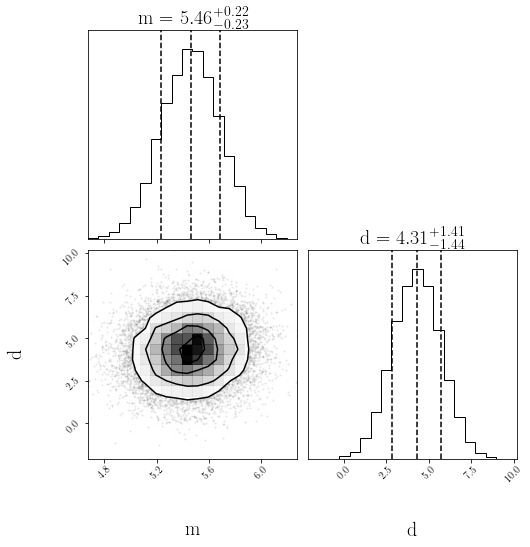

In [6]:
nsim = 20000
bootstrap_m = np.zeros(nsim)
bootstrap_d = np.zeros(nsim)
fails = []

for i in range(nsim):
    bootstrap_y = np.random.normal(data_y,data_dy)
    bootstrap_minres = minimize(negloglikelihood, [5, 5], args=(data_x, bootstrap_y, data_dy))
    if bootstrap_minres.status == 0:
        bootstrap_m[i] = bootstrap_minres.x[0]
        bootstrap_d[i] = bootstrap_minres.x[1]
    else:
        fails.append(i)


print(f'minimize failed {len(fails)} times.')
bootstrap_m = np.delete(bootstrap_m,fails)
bootstrap_d = np.delete(bootstrap_d,fails)

fig = plt.figure(figsize=(8,8))
plot = corner(list(zip(*[bootstrap_m,bootstrap_d])),labels=['m','d'], show_titles=True, fig=fig,
              title_kwargs={"fontsize": 20},label_kwargs={"fontsize": 20}, quantiles=[0.16, 0.5, 0.84])

## Method 3: Delta statistics

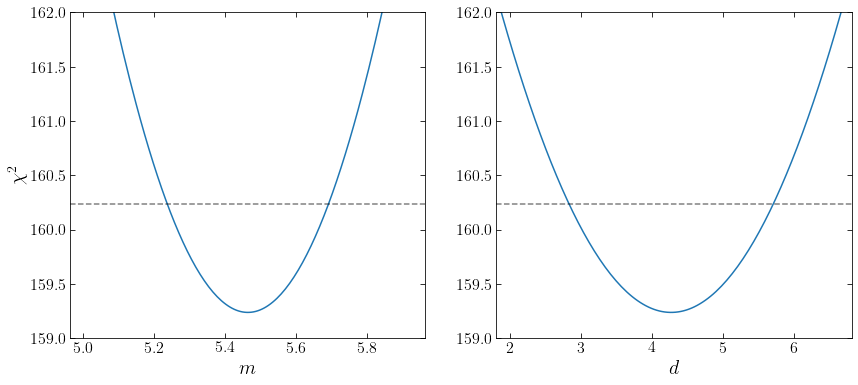

In [7]:
def chi2(x,y,dy, m, d):
    return sum(((y - model(x,m,d))/dy)**2)

# Brute-force grid search
axis_grid_points = 500
m_array = np.linspace(4.0,7.0,axis_grid_points)
d_array = np.linspace(-5,14,axis_grid_points)
chi2_matrix = np.ones([axis_grid_points, axis_grid_points])*1e6

#for i, m_i in enumerate(m_array):
#    for j, d_j in enumerate(d_array):
#        chi2_matrix[i,j] = chi2(data_x,data_y,data_dy,m_i,d_j)

res = Parallel(n_jobs=12)(delayed(chi2)(data_x,data_y,data_dy,m_i,d_j) for i,m_i in enumerate(m_array) for j,d_j in enumerate(d_array))
chi2_matrix = np.reshape(res, (-1, len(d_array)))
     
min_redchi2 = chi2_matrix.min()

fig = plt.figure(figsize=(14,6))
ax1 = fig.add_subplot(1,2,1)
ax1.plot(m_array,[chi2_matrix[i_m].min() for i_m in range(len(m_array))])
ax1.axhline(min([chi2_matrix[i_m].min() for i_m in range(len(m_array))])+1,color='k',alpha=0.5,linestyle='--')
ax1.set(xlim=[bestfit_m-0.5,bestfit_m+0.5],ylim=[159,162])
ax1.set_ylabel(r'$\chi^2$',fontsize=20)
ax1.set_xlabel(r'$m$',fontsize=20);
ax2 = fig.add_subplot(1,2,2)
ax2.plot(d_array,[chi2_matrix[i_d].min() for i_d in range(len(d_array))])
ax2.axhline(min([chi2_matrix[i_d].min() for i_d in range(len(d_array))])+1,color='k',alpha=0.5,linestyle='--')
ax2.set(xlim=[bestfit_d-2.5,bestfit_d+2.5],ylim=[159,162])
#ax2.set_ylabel(r'$\chi^2$',fontsize=20)
ax2.set_xlabel(r'$d$',fontsize=20);
ax1.tick_params(axis='both', which='major', labelsize=16)
ax1.tick_params(axis='both', which='major', length=5)
ax1.tick_params(axis='both', which='minor', length=2.5)
ax1.tick_params(axis='both', which='both',direction='in',right=True,top=True)
ax2.tick_params(axis='both', which='major', labelsize=16)
ax2.tick_params(axis='both', which='major', length=5)
ax2.tick_params(axis='both', which='minor', length=2.5)
ax2.tick_params(axis='both', which='both',direction='in',right=True,top=True)

## Comaring delta and bootstrap:

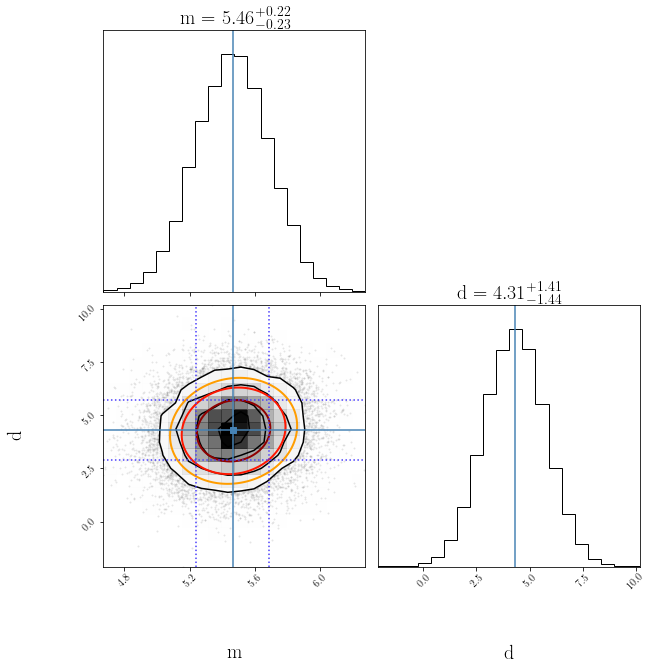

In [8]:
fig = plt.figure(figsize=(10,10))
plot = corner(list(zip(*[bootstrap_m,bootstrap_d])),labels=['m','d'], show_titles=True, fig=fig,
              truths = [bestfit_m, bestfit_d],
              title_kwargs={"fontsize": 20},label_kwargs={"fontsize": 20})
ct_ax = plot.get_axes()[2]
cmap_norm = colors.Normalize(vmin=chi2_matrix.min(), vmax=chi2_matrix.min()+5)
clevels = [min_redchi2+1,min_redchi2+2,min_redchi2+3]
ct_ax.contour(m_array,d_array,chi2_matrix,clevels,cmap='hot',norm=cmap_norm,linewidths=2)
ct_ax.axhline(bestfit_d - fisher_delta_d,linestyle=':',color=colorset[5])
ct_ax.axhline(bestfit_d + fisher_delta_d,linestyle=':',color=colorset[5])
ct_ax.axvline(bestfit_m - fisher_delta_m,linestyle=':',color=colorset[5])
ct_ax.axvline(bestfit_m + fisher_delta_m,linestyle=':',color=colorset[5])